# Sentiment Analysis Project: TV One Youtube Comments

## Prepare the Requirements

In [ ]:
!pip install emoji youtube-comment-downloader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 13.1 MB/s eta 0:00:00


In [ ]:
import json
from youtube_comment_downloader import YoutubeCommentDownloader

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
import emoji

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
import tensorflow as tf
import torch
from transformers import BertModel, BertTokenizer, pipeline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GRU, \
Embedding, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

## Scraping

In [ ]:
# via CLI
!youtube-comment-downloader -u https://www.youtube.com/watch?v=SfVZZkikt7U -p -o dataset.json

Downloaded 21462 comment(s)
[296.11 seconds] Done!


In [ ]:
# via code
downloader = YoutubeCommentDownloader()
url = 'https://www.youtube.com/watch?v=SfVZZkikt7U'
output_file = 'dataset.json'

comments = list(downloader.get_comments_from_url(url))

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(comments, f, ensure_ascii=False, indent=4)

print(f'{len(comments)} komentar telah disimpan ke {output_file}')

## Data Loading

### Dataset

In [ ]:
df = pd.read_json('dataset.json')

# jalankan jika menggunakan via CLI
# df = pd.json_normalize(df['comments'])[['text']]

df.head()

,cid,text,time,author,channel,votes,replies,photo,heart,reply,time_parsed,paid
0,UgyU2xNUoGBwU4fLcPp4AaABAg,Karena fufu fafa kedeteksi,1 hour ago,@Nyong-l2h,UCxthxqhuypqNfgMUn3zCqIg,0,,https://yt3.ggpht.com/ytc/AIdro_kha02_9Ul-0i7-...,False,False,1.725794e+09,NaN
1,UgwBwHWFrlSO180J8Nh4AaABAg,"Dulu saya ngefans sama ahox, sekarang ko jadi ...",2 hours ago,@triparibani5828,UCpVfN_UWcrtXwl7dOCN9ecQ,0,,https://yt3.ggpht.com/ytc/AIdro_m81Y6ga2znh_47...,False,False,1.725790e+09,NaN
2,Ugz0cuBjUp1-qyo3bd94AaABAg,Ahok2 kamu gk ada pk jkw. Sampa taak berguna hok,4 hours ago,@sabarsadar1375,UC8g-WdOFYpLxmdK0546ZuIw,0,,https://yt3.ggpht.com/ytc/AIdro_kghj6IsyrE1N06...,False,False,1.725783e+09,NaN
3,UgyMP_S4IyasB5a5tol4AaABAg,Gibran betul gk bisa krja dan gk bisa bicara l...,5 hours ago,@MonicUyeee,UCwdaqA4AwYwT-QXy6iib5nA,0,,https://yt3.ggpht.com/ytc/AIdro_kIQd925lZn3kNv...,False,False,1.725779e+09,NaN
4,UgyAfWQm5wwruyWun3J4AaABAg,Habiborokman ini pecundang,5 hours ago,@MonicUyeee,UCwdaqA4AwYwT-QXy6iib5nA,0,,https://yt3.ggpht.com/ytc/AIdro_kIQd925lZn3kNv...,False,False,1.725779e+09,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21462 entries, 0 to 21461
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cid          21462 non-null  object 
 1   text         21462 non-null  object 
 2   time         21462 non-null  object 
 3   author       21462 non-null  object 
 4   channel      21462 non-null  object 
 5   votes        21462 non-null  object 
 6   replies      21462 non-null  object 
 7   photo        21462 non-null  object 
 8   heart        21462 non-null  bool   
 9   reply        21462 non-null  bool   
 10  time_parsed  21462 non-null  float64
 11  paid         1 non-null      object 
dtypes: bool(2), float64(1), object(9)
memory usage: 1.7+ MB


### Lexicon

In [ ]:
lexicon_url = 'https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv'
lexicon_corpus = pd.read_csv(lexicon_url)

lexicon_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15006 entries, 0 to 15005
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   slang          15006 non-null  object
 1   formal         15006 non-null  object
 2   In-dictionary  15006 non-null  int64 
 3   context        15006 non-null  object
 4   category1      15006 non-null  object
 5   category2      15006 non-null  object
 6   category3      15006 non-null  object
dtypes: int64(1), object(6)
memory usage: 820.8+ KB


In [ ]:
# drop nilai nan di dalam corpus lexicon, yang kata formalnya tidak ada
lexicon_corpus = lexicon_corpus.dropna(subset=['formal'])
lexicon_corpus = lexicon_corpus.drop_duplicates(subset=['slang'])

lexicon_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4331 entries, 0 to 15005
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   slang          4331 non-null   object
 1   formal         4331 non-null   object
 2   In-dictionary  4331 non-null   int64 
 3   context        4331 non-null   object
 4   category1      4331 non-null   object
 5   category2      4331 non-null   object
 6   category3      4331 non-null   object
dtypes: int64(1), object(6)
memory usage: 270.7+ KB


## Data Cleaning

In [ ]:
slang_formal_dict = dict(zip(lexicon_corpus['slang'], lexicon_corpus['formal']))

def cleaning_text(text):
    clean_text = text.lower()

    clean_text = emoji.replace_emoji(clean_text, replace='')

    clean_text = re.sub(r'@\w+[-\w]+', '', clean_text)
    clean_text = re.sub(r'\n+', '', clean_text)
    clean_text = re.sub(r'\b\d{1,2}:\d{2}\b', '', clean_text)

    clean_text = re.sub(r'http\S+|www\S+|https\S+', '', clean_text, flags=re.MULTILINE)

    clean_text = re.sub(r'\d+', '', clean_text)
    clean_text = re.sub(r'[{}]+'.format(re.escape(string.punctuation)), ' ', clean_text)
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    clean_text = clean_text.replace('@','')
    # print(f'{text} -> {clean_text}')
    clean_text = ' '.join([word for word in clean_text.split() if len(word) > 1])

    return clean_text

def replace_slang(text, slang_formal_dict):
    pattern = re.compile(r'\b({})\b'.format('|'.join(map(re.escape, slang_formal_dict.keys()))))
    return pattern.sub(lambda match: slang_formal_dict[match.group(0)], text)

def preprocess_text(text):
    text = cleaning_text(text)
    text = replace_slang(text, slang_formal_dict)
    return text

In [ ]:
df['clean_text'] = df['text'].apply(preprocess_text)

Streaming output truncated to the last 5000 lines.
Apa sih yg di bicarakan,,, sombong banget lo pak ceplas ceplos ngomongnya, jangan dengerin mas gibran tegak lurus aja saya kokoh pilih PRAGIB ✌JARI -> apa sih yg di bicarakan sombong banget lo pak ceplas ceplos ngomongnya jangan dengerin mas gibran tegak lurus aja saya kokoh pilih pragib jari
Kenapa gak di balikpapan ya balikpapan aja setiap hujan selalu banjir -> kenapa gak di balikpapan ya balikpapan aja setiap hujan selalu banjir
Silahkan ngoceh semau lo.....tetap prabowo gibran lanjutkan..!!! -> silahkan ngoceh semau lo tetap prabowo gibran lanjutkan
Tambah seneng Prabowo jadi presiden,jadi gak gampang orang menghina hina kepala negara..,
Selama jaman presiden Jokowi banyak yg suka hujat hujat ,pak Jokowi dieeem aja kurang teges.. -> tambah seneng prabowo jadi presiden jadi gak gampang orang menghina hina kepala negara selama jaman presiden jokowi banyak yg suka hujat hujat pak jokowi dieeem aja kurang teges
Ahok mantan narapidana 

In [ ]:
df_clean = df[['text', 'clean_text']]

df_clean.head()

,text,clean_text
0,Karena fufu fafa kedeteksi,karena fufu fafa kedeteksi
1,"Dulu saya ngefans sama ahox, sekarang ko jadi ...",dulu saya fan sama ahox sekarang kok jadi sebe...
2,Ahok2 kamu gk ada pk jkw. Sampa taak berguna hok,ahok kamu enggak ada pakai jkw sampa taak berg...
3,Gibran betul gk bisa krja dan gk bisa bicara l...,gibran betul enggak bisa krja dan enggak bisa ...
4,Habiborokman ini pecundang,habiborokman ini pecundang


In [ ]:
print(f'Duplicates: {df_clean.duplicated(subset="clean_text").sum()}')
df_clean = df_clean.drop_duplicates(subset='clean_text')

df_clean.info()

Duplicates: 1009
<class 'pandas.core.frame.DataFrame'>
Index: 20453 entries, 0 to 21461
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        20453 non-null  object
 1   clean_text  20453 non-null  object
dtypes: object(2)
memory usage: 479.4+ KB


In [ ]:
df_clean[df_clean.clean_text.str.split().str.len() <= 2].sample(5)

,text,clean_text
20980,Setingan,setingan
17825,Banteng panas,banteng panas
2741,Same here!!,same here
18100,Sepaham👍👍👍👍​ @haikalgaminghaikalff2188,sepaham​
11627,Singkek nyocot....,singkek nyocot


In [ ]:
df_clean = df_clean[(df_clean.clean_text.str.split().str.len() > 2) & (df_clean.clean_text.str.len() < 2000)]

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19381 entries, 0 to 21461
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        19381 non-null  object
 1   clean_text  19381 non-null  object
dtypes: object(2)
memory usage: 454.2+ KB


## Labeling

In [ ]:
sentiment_analysis = pipeline("text-classification", model="Aardiiiiy/indobertweet-base-Indonesian-sentiment-analysis")
# sentiment_analysis = pipeline("text-classification", model="mdhugol/indonesia-bert-sentiment-classification")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/994 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
label_replace = {
    'LABEL_0': 'positive',
    'LABEL_1': 'neutral',
    'LABEL_2': 'negative'
}

# Fungsi untuk menganalisis sentimen teks
def get_sentiment(text):
    label = sentiment_analysis(text)[0]['label']
    # uncomment jika menggunakan model kedua
    # print(f'{text} -> {label_replace[label]}')
    print(f'{text} -> {label}')

    return label

In [ ]:
df_clean['label'] = df_clean['clean_text'].apply(get_sentiment)

df_clean[['clean_text', 'label']].head()

Streaming output truncated to the last 5000 lines.
saya yakin dengan adanya ahok pragib menang putaran trimakasih ahok rakyat indonesia sudah tau sifat anda sesungguhnya alhamdulillah ahok ini tidak masuk dalam tkn pragib bisa hancur elektabilitas -> Positive
ketenaran ahok dan kejayaannya sudah kedaluwarsa dan expayet -> Negative
ini adalah permainan catur pak jokowi -> Neutral
hati kebangkitan pdi yang sudah cukup menyengsarakan rakyat -> Negative
upaya ahok tegelamkan pdi pdri dalam -> Neutral
ahok soook pintar pengkianat pada pak jokowi save ahok bubar sekarang orang tidak tahu di kasihani -> Negative
jika kehabisan argumen jika sedang tak punya argumen maka katakan saja preetttt karena itulah yang paling nyata mewakili jati diri -> Negative
all ini prabowo -> Positive
suara reporter nyinyir cawapres no urut di menit ke gila sih ini dibikin supaya mereka dicintai -> Negative
mungkin betul kata ahok bisa kerja wong gibran kelihatannya loyo kurang gizi mungkin kecilnya primatur -> Ne

,clean_text,label
0,karena fufu fafa kedeteksi,Negative
1,dulu saya fan sama ahox sekarang kok jadi sebe...,Negative
2,ahok kamu enggak ada pakai jkw sampa taak berg...,Negative
3,gibran betul enggak bisa krja dan enggak bisa ...,Negative
4,habiborokman ini pecundang,Negative


In [ ]:
df_clean.to_csv('dataset_labeled.csv', index=False)
df = pd.read_csv('dataset_labeled.csv')

df.head()

,text,clean_text,label
0,Karena fufu fafa kedeteksi,karena fufu fafa kedeteksi,Negative
1,"Dulu saya ngefans sama ahox, sekarang ko jadi ...",dulu saya fan sama ahox sekarang kok jadi sebe...,Negative
2,Ahok2 kamu gk ada pk jkw. Sampa taak berguna hok,ahok kamu enggak ada pakai jkw sampa taak berg...,Negative
3,Gibran betul gk bisa krja dan gk bisa bicara l...,gibran betul enggak bisa krja dan enggak bisa ...,Negative
4,Habiborokman ini pecundang,habiborokman ini pecundang,Negative


In [ ]:
df.label.value_counts()

,count
label,
Negative,13641
Positive,3138
Neutral,2602


In [ ]:
df[(df.label == 'Negative') & (df.clean_text.str.split().str.len() <= 10)]

,text,clean_text,label
0,Karena fufu fafa kedeteksi,karena fufu fafa kedeteksi,Negative
2,Ahok2 kamu gk ada pk jkw. Sampa taak berguna hok,ahok kamu enggak ada pakai jkw sampa taak berg...,Negative
4,Habiborokman ini pecundang,habiborokman ini pecundang,Negative
5,Banyak ngomong ahok,banyak mengomong ahok,Negative
6,Gila si Ahok kenapa dilepas harusnya dia membu...,gila sih ahok kenapa dilepas harusnya dia memb...,Negative
...,...,...,...
19364,pada gila kalo sudah join banteng,pada gila kalo sudah join banteng,Negative
19367,Ngomong Taek hok hokk,mengomong tahi hok hokk,Negative
19368,Air tuba di balas air susu,air tuba di balas air susu,Negative
19376,Wandi gobloknya ga ketulungan,wandi gobloknya enggak ketulungan,Negative


In [ ]:
df = df[~((df.label == 'Negative') & (df.clean_text.str.split().str.len() <= 10))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12844 entries, 1 to 19380
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        12844 non-null  object
 1   clean_text  12844 non-null  object
 2   label       12844 non-null  object
dtypes: object(3)
memory usage: 401.4+ KB


In [ ]:
df.label.value_counts()

,count
label,
Negative,7104
Positive,3138
Neutral,2602


## Machine Learning Algorithm

### Schema: Single Model

#### Feature Extraction with TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.9)

# Calculate the TF-IDF vectors
text_vectorized = vectorizer.fit_transform(df['clean_text']).toarray()

#### Train-Test Split

In [ ]:
X = text_vectorized
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

#### Balancing Data with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
import numpy as np

# Menghitung jumlah kemunculan setiap nilai dalam y_train_resampled
unique, counts = np.unique(y_train_resampled, return_counts=True)

# Menggabungkan nilai unik dengan jumlah kemunculannya
value_counts = dict(zip(unique, counts))

print(value_counts)

{'Negative': 6393, 'Neutral': 6393, 'Positive': 6393}


#### Modeling with SVM

In [ ]:
svc = SVC(C=100, gamma=1, kernel='rbf')
svc.fit(X_train_resampled, y_train_resampled)

SVC(C=100, gamma=1)

In [ ]:
y_pred = svc.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7704280155642024
              precision    recall  f1-score   support

    Negative       0.79      0.91      0.84       711
     Neutral       0.70      0.54      0.61       260
    Positive       0.76      0.65      0.70       314

    accuracy                           0.77      1285
   macro avg       0.75      0.70      0.72      1285
weighted avg       0.77      0.77      0.76      1285



### Schema: Multi Model

#### Encoding Label

In [ ]:
X = df['clean_text']
y = df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

#### Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42)

y_train.shape, y_test.shape

#### Prepare Balacing Algorithm

In [ ]:
smote = SMOTE(random_state=42)
under_sampler = RandomUnderSampler(random_state=42)
over_sampler = RandomOverSampler(random_state=42)

#### Modeling by Pipeline

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0, solver='liblinear', multi_class='ovr', random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=None, criterion='gini', random_state=42),
    'SVM': SVC(kernel='rbf', C=1.0, decision_function_shape='ovr', random_state=42)
}

param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    'Decision Tree': {
        'classifier__max_depth': [10, 20, None],
        'classifier__criterion': ['gini', 'entropy']
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf']
    }
}

tokenizers = {
    'TF-IDF': TfidfVectorizer(max_features=5000, min_df=5, max_df=0.9),
    'Count Vectorizer': CountVectorizer(max_features=5000, min_df=5, max_df=0.9),
    'Hashing Vectorizer': HashingVectorizer(n_features=5000)
}

sampling_methods = {
    'None': None,
    'SMOTE': smote,
    'Random Under Sampling': under_sampler,
    'Random Over Sampling': over_sampler
}

results = []
for model_name, model in models.items():
    for tokenizer_name, tokenizer in tokenizers.items():
        for sampling_name, sampler in sampling_methods.items():
                steps = [('tokenizer', tokenizer)]

                if sampler:
                    steps.append(('sampling', sampler))

                steps.append(('classifier', model))

                pipeline = Pipeline(steps)
                param_grid = param_grids.get(model_name, {})
                grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', n_jobs=-1, verbose=1)
                grid_search.fit(X_train, y_train)

                y_pred_train = grid_search.predict(X_train)
                y_pred_test = grid_search.predict(X_test)

                accuracy_train = accuracy_score(y_train, y_pred_train)
                accuracy_test = accuracy_score(y_test, y_pred_test)

                results.append({
                    'Model': model_name,
                    'Tokenizer': tokenizer_name,
                    'Sampling Method': sampling_name,
                    'Best Params': grid_search.best_params_,
                    'Accuracy Train': accuracy_train,
                    'Accuracy Test': accuracy_test
                })

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Fitting 2 folds for each of 6 candidates

#### Show Modeling Result

In [ ]:
results_df = pd.DataFrame(results)
display(results_df)

,Model,Tokenizer,Sampling Method,Best Params,Accuracy Train,Accuracy Test
0,Logistic Regression,TF-IDF,None,"{'classifier__C': 10, 'classifier__solver': 'l...",0.897569,0.775097
1,Logistic Regression,TF-IDF,SMOTE,"{'classifier__C': 1, 'classifier__solver': 'li...",0.827753,0.767315
2,Logistic Regression,TF-IDF,Random Under Sampling,"{'classifier__C': 1, 'classifier__solver': 'li...",0.787698,0.737743
3,Logistic Regression,TF-IDF,Random Over Sampling,"{'classifier__C': 1, 'classifier__solver': 'li...",0.831300,0.757977
4,Logistic Regression,Count Vectorizer,None,"{'classifier__C': 1, 'classifier__solver': 'lb...",0.888226,0.779767
5,Logistic Regression,Count Vectorizer,SMOTE,"{'classifier__C': 1, 'classifier__solver': 'li...",0.880353,0.773541
6,Logistic Regression,Count Vectorizer,Random Under Sampling,"{'classifier__C': 0.1, 'classifier__solver': '...",0.776192,0.745525
7,Logistic Regression,Count Vectorizer,Random Over Sampling,"{'classifier__C': 1, 'classifier__solver': 'lb...",0.890475,0.774319
8,Logistic Regression,Hashing Vectorizer,None,"{'classifier__C': 10, 'classifier__solver': 'l...",0.870837,0.754086
9,Logistic Regression,Hashing Vectorizer,SMOTE,"{'classifier__C': 10, 'classifier__solver': 'l...",0.873259,0.736965


In [ ]:
results_df.nlargest(5, 'Accuracy Test')

,Model,Tokenizer,Sampling Method,Best Params,Accuracy Train,Accuracy Test
28,SVM,Count Vectorizer,None,"{'classifier__C': 1, 'classifier__kernel': 'rbf'}",0.884419,0.789883
4,Logistic Regression,Count Vectorizer,None,"{'classifier__C': 1, 'classifier__solver': 'lb...",0.888226,0.779767
31,SVM,Count Vectorizer,Random Over Sampling,"{'classifier__C': 10, 'classifier__kernel': 'r...",0.994723,0.779767
32,SVM,Hashing Vectorizer,None,"{'classifier__C': 10, 'classifier__kernel': 'r...",0.999827,0.779767
35,SVM,Hashing Vectorizer,Random Over Sampling,"{'classifier__C': 10, 'classifier__kernel': 'r...",0.999827,0.779767


## Deep Learning Algorithm

### Schema: Feature Extraction with Tokenizer

#### Encoding Label

In [ ]:
X = df['clean_text']
y = df['label']

le = LabelEncoder()
y = le.fit_transform(y)

# num_classes = y.nunique()
num_classes = len(np.unique(y))
num_classes

3

#### Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

y_train.shape, y_test.shape

((17442,), (1939,))

#### Feature Extraction

In [ ]:
# Tokenisasi teks
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Konversi teks menjadi sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding sequences
max_length = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

# Konversi label menjadi categorical
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

#### Balancing Data

In [ ]:
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train_padded, y_train_categorical)

#### Modeling with GRU

In [ ]:
# Explore model
model_gru1 = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    Bidirectional(GRU(128, dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.01))),
    BatchNormalization(),
    Bidirectional(GRU(128, dropout=0.3, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])

# Compile model
model_gru1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
model_gru1.fit(X_train_padded, y_train_categorical, epochs=20, batch_size=32,
                    validation_data=(X_test_padded, y_test_categorical),
                    callbacks=[early_stop, reduce_lr])

# Evaluate the model
loss, accuracy = model_gru1.evaluate(X_test_padded, y_test_categorical, verbose=2)
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.7185 - loss: 4.5542 - val_accuracy: 0.7530 - val_loss: 0.7215 - learning_rate: 0.0010
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.7871 - loss: 0.6196 - val_accuracy: 0.7674 - val_loss: 0.6171 - learning_rate: 0.0010
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.8119 - loss: 0.5430 - val_accuracy: 0.7710 - val_loss: 0.6543 - learning_rate: 0.0010
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.8388 - loss: 0.4841 - val_accuracy: 0.7849 - val_loss: 0.5806 - learning_rate: 0.0010
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.8500 - loss: 0.4598 - val_accuracy: 0.7267 - val_loss: 1.0115 - learning_rate: 0.0010
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.8229 - loss: 0.6165 - val_accuracy: 0.7741 - val_loss: 0.6177 - learning_rate: 0.0010
Epoch 7/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8855 - l

In [ ]:
# Explore model
model_gru2 = Sequential([
    Embedding(input_dim=5000, output_dim=128, embeddings_regularizer=l2(0.01)),
    Dropout(0.5),  # Dropout lebih awal
    Bidirectional(GRU(64, dropout=0.3, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(num_classes, activation='softmax'),
])

# Compile model
model_gru2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_gru2.fit(X_train_padded, y_train_categorical, epochs=20, batch_size=32,
                    validation_data=(X_test_padded, y_test_categorical),
                    callbacks=[early_stop, reduce_lr])

# Evaluate the  model
loss, accuracy = model_gru2.evaluate(X_test_padded, y_test_categorical, verbose=2)
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.6915 - loss: 1.7325 - val_accuracy: 0.7421 - val_loss: 0.8462 - learning_rate: 0.0010
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7548 - loss: 0.8146 - val_accuracy: 0.7571 - val_loss: 0.8229 - learning_rate: 0.0010
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7657 - loss: 0.8147 - val_accuracy: 0.7592 - val_loss: 0.8240 - learning_rate: 0.0010
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7742 - loss: 0.8062 - val_accuracy: 0.7710 - val_loss: 0.8057 - learning_rate: 0.0010
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7822 - loss: 0.7999 - val_accuracy: 0.7788 - val_loss: 0.7956 - learning_rate: 0.0010
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7894 - loss: 0.7869 - val_accuracy: 0.7782 - val_loss: 0.7886 - learning_rate: 0.0010
Epoch 7/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7934 - loss:

### Schema: Feature Extraction with BERT Model
Reference: [Kaggle](https://www.kaggle.com/code/sujithmandala/simple-feature-extractor-bert-model#Simple-Feature-Extractor-using-BERT-Model)

In [ ]:
# Load the pre-trained BERT model and tokenizer
model = BertModel.from_pretrained('Aardiiiiy/indobertweet-base-Indonesian-sentiment-analysis', output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('Aardiiiiy/indobertweet-base-Indonesian-sentiment-analysis')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/994 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

#### Feature Extraction

In [ ]:
def extract_features(text):
    # Tokenize the text
    input_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)])
    # Get the hidden states for each token
    with torch.no_grad():
        outputs = model(input_ids)
        hidden_states = outputs[2]
    # Concatenate the last 4 hidden states
    token_vecs = []
    for layer in range(-4, 0):
        token_vecs.append(hidden_states[layer][0])
    # Calculate the mean of the last 4 hidden states
    features = []
    for token in token_vecs:
        features.append(torch.mean(token, dim=0))
    # Return the features as a tensor
    return torch.stack(features)

In [ ]:
# Extract features for each transaction using batch processing
def extract_features_batch(texts, model, tokenizer):
    features = []
    for text in texts:
        features.append(extract_features(text))
    return torch.cat(features)

# Assume df_first_schema['text'] and df_first_schema['label'] are available
texts = df['clean_text'].tolist()  # Convert to list for faster access
labels = df['label'].values  # Convert labels to numpy array

# Extract features in a batch
features = extract_features_batch(texts, model, tokenizer)

In [ ]:
features.shape, labels.shape

(torch.Size([77524, 768]), (19381,))

In [ ]:
# Reshape the features to match the number of labels
features_reshaped = features.numpy().reshape((labels.shape[0], -1))

# Concatenate the feature array with the label array horizontally
dataset = np.hstack((features_reshaped, labels.reshape((-1, 1))))

dataset.shape

(19381, 3073)

In [ ]:
df_dataset = pd.DataFrame(dataset)

df_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072
0,0.032219,-0.392085,0.285212,0.172241,0.162036,-0.073998,-0.196916,-0.064275,-0.051507,-0.169618,...,-0.607448,0.426366,0.215963,-0.608239,-0.034017,-0.108506,-0.059506,-0.795336,0.429337,Negative
1,0.028315,-0.322124,-0.054836,0.225705,0.027416,-0.134261,-0.250157,-0.19129,-0.044812,-0.057711,...,0.201282,0.908832,-0.361768,-0.768767,-0.197595,-0.97571,0.186495,-0.450269,0.069529,Negative
2,0.146457,-0.129269,-0.269031,0.212139,0.300264,0.220631,-0.15198,-0.133202,-0.035016,0.121924,...,0.113645,1.051578,-0.227994,-1.224793,0.134197,0.084218,-0.369607,-0.585267,0.232749,Neutral
3,-0.035302,-0.132719,-0.016314,0.163906,0.219886,-0.087414,-0.196805,-0.064221,0.016676,0.114057,...,-0.306781,0.41018,0.310087,-0.320195,1.129926,0.130652,0.367103,-1.730255,0.289158,Neutral
4,0.210651,-0.132529,0.066793,0.310198,0.184088,-0.019686,-0.266485,-0.167528,-0.054274,0.070855,...,-0.442045,0.122105,0.737012,0.041937,-0.120997,0.431462,0.07975,-0.200191,0.504246,Positive


#### Train-Test Split + Encoding Label

In [ ]:
X = dataset[:, :-1]
y = dataset[:, -1]

# label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, stratify=y_encoded, random_state=42)

y_train.shape, y_test.shape

((17442,), (1939,))

In [ ]:
# show labeling result
label_mapping = dict(zip(range(len(le.classes_)), le.classes_))
for key, value in label_mapping.items():
    print(f'Encoded {key} for {value}')

Encoded 0 for Negative
Encoded 1 for Neutral
Encoded 2 for Positive


#### Balancing Data

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Reshape the input data for LSTM/GRU input (samples, timesteps, features)
timesteps = X_train_resampled.shape[1] // 768  # Assuming BERT embeddings of 768 dimensions
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], timesteps, 768))
X_test = X_test.reshape((X_test.shape[0], timesteps, 768))

In [ ]:
# Konversi label menjadi one-hot encoding
y_train_ohe = to_categorical(y_train_resampled, num_classes=3)
y_test_ohe = to_categorical(y_test, num_classes=3)

y_train_ohe

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

#### Modeling with LSTM

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print('Class Weights:', class_weights_dict)

Class Weights: {0: 0.4736070381231672, 1: 2.4824935952177625, 2: 2.058781869688385}


In [ ]:
# ReduceLROnPlateau to reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    min_lr=0.000001,
    verbose=2
)

# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    restore_best_weights=True,
    verbose=2
)

In [ ]:
# Define the model using Input layer
input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])

model_lstm = Sequential([
    Input(shape=input_shape),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(units=3, activation='softmax')
])

# Compile model
model_lstm.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Convert NumPy arrays to TensorFlow Tensors
X_train_resampled = tf.convert_to_tensor(X_train_resampled, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

model_lstm.fit(X_train_resampled, y_train_ohe,
               verbose=2, epochs=50, batch_size=32,
               validation_data=(X_test, y_test_ohe),
               class_weight=class_weights_dict,
               callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1151/1151 - 8s - 7ms/step - accuracy: 0.9122 - loss: 0.2824 - val_accuracy: 0.9551 - val_loss: 0.1025 - learning_rate: 1.0000e-04
Epoch 2/50
1151/1151 - 5s - 5ms/step - accuracy: 0.9754 - loss: 0.0733 - val_accuracy: 0.9634 - val_loss: 0.0842 - learning_rate: 1.0000e-04
Epoch 3/50
1151/1151 - 11s - 10ms/step - accuracy: 0.9830 - loss: 0.0479 - val_accuracy: 0.9727 - val_loss: 0.0692 - learning_rate: 1.0000e-04
Epoch 4/50
1151/1151 - 5s - 5ms/step - accuracy: 0.9875 - loss: 0.0333 - val_accuracy: 0.9794 - val_loss: 0.0550 - learning_rate: 1.0000e-04
Epoch 5/50
1151/1151 - 7s - 6ms/step - accuracy: 0.9898 - loss: 0.0277 - val_accuracy: 0.9794 - val_loss: 0.0516 - learning_rate: 1.0000e-04
Epoch 6/50
1151/1151 - 9s - 8ms/step - accuracy: 0.9915 - loss: 0.0215 - val_accuracy: 0.9804 - val_loss: 0.0479 - learning_rate: 1.0000e-04
Epoch 7/50
1151/1151 - 6s - 5ms/step - accuracy: 0.9929 - loss: 0.0175 - val_accuracy: 0.9845 - val_loss: 0.0371 - learning_rate: 1.0000e-04
Epoch 8/50


In [ ]:
# Predict
y_pred = model_lstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_ohe, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes))

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1365
           1       0.95      0.98      0.96       260
           2       0.97      0.97      0.97       314

    accuracy                           0.98      1939
   macro avg       0.97      0.98      0.98      1939
weighted avg       0.98      0.98      0.98      1939



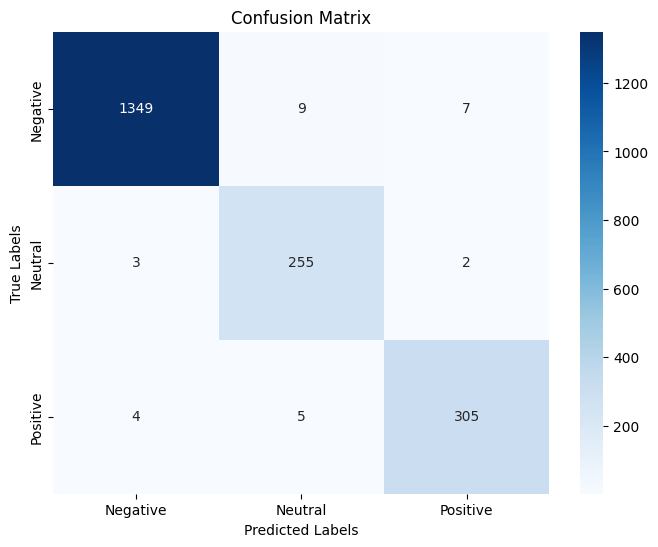

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Save Best Model

In [ ]:
# save the best model
model_lstm.save('best_model.keras')

In [ ]:
best_model = tf.keras.models.load_model('best_model.keras')

# Show the model architecture
best_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │         213,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 646,283 (2.47 MB)

 Trainable params: 215,427 (841.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 430,856 (1.64 MB)

## Inference (With Best Model)

In [ ]:
def preprocess_for_inference(text, model, tokenizer):
    # Ekstraksi fitur untuk setiap teks
    features = extract_features_batch(text, model, tokenizer)

    # Normalisasi data
    features_np = features.numpy()

    # Reshape data untuk input LSTM/GRU
    timesteps = features_np.shape[1] // 768  # Sesuaikan dengan dimensi embedding BERT
    features_reshaped = features_np.reshape((features_np.shape[0], timesteps, 768))

    return features_reshaped

def predict(text):
    # Proses teks input
    text = preprocess_text(text)
    X_infer = preprocess_for_inference([text], model, tokenizer)

    # Melakukan inferensi
    predictions = best_model.predict(X_infer)
    predicted_classes = np.argmax(predictions, axis=1)

    # Konversi indeks kelas ke label menggunakan LabelEncoder
    predicted_labels = le.inverse_transform(predicted_classes)

    return predicted_labels

In [ ]:
df[df.label=='Positive']['clean_text'].sample(5)

,clean_text
6609,gass gibran selalu di
11551,indonesia tanpa ahok juga bisa maju peribumi a...
7427,nak gibran yang sabar ya semoga sukses terus l...
185,prabowo siap maju juga siap pak prabowo komado...
14647,orang sing shou win sudah berkuasa di indonesia


In [ ]:
import ipywidgets as widgets
from IPython.display import display

def on_button_click(b):
    text = text_box.value
    if text:
        result = predict(text)
        print(f'{text} --> {result[0]}')
    else:
        print('Please enter some text.')

# Widget input teks
text_box = widgets.Text(
    description='Input Text:',
    placeholder='Type your text here'
)

# Widget button
button = widgets.Button(description="Predict")
button.on_click(on_button_click)

widgets_box = widgets.HBox([text_box, button])
display(widgets_box)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
aku bangga dengan kinerja pak jokowi --> Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
lebih baik jangan ribut kalau ga paham politik --> Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
bacot banget lu jadi netizen --> Negative


## Generate Requirements

In [ ]:
!pip install pipreqs

  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 kB 25.5 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 4.6 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=e2c42ecad813bf31c0ceb66e89c1e05b3138622e1ca76e1cbbf8c7f49c158c4d
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
  Attempting uninstall: mistune
    Found existing installation: mistune 0.8.4
    Uninstalling mistune-0.8.4:
      Successfully uninstalled mistune-0.8.4
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pipreqs '/content/drive/MyDrive/Colab Notebooks/TE' --scan-notebooks --force

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in /content/drive/MyDrive/Colab Notebooks/TE/requirements.txt
